# Faster_RCNN : Object Detection 
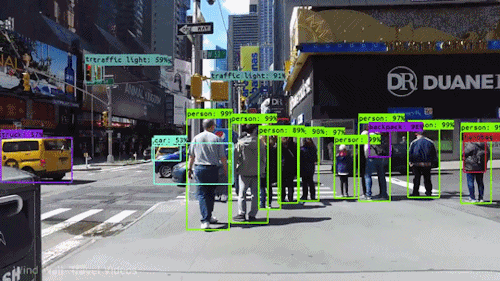

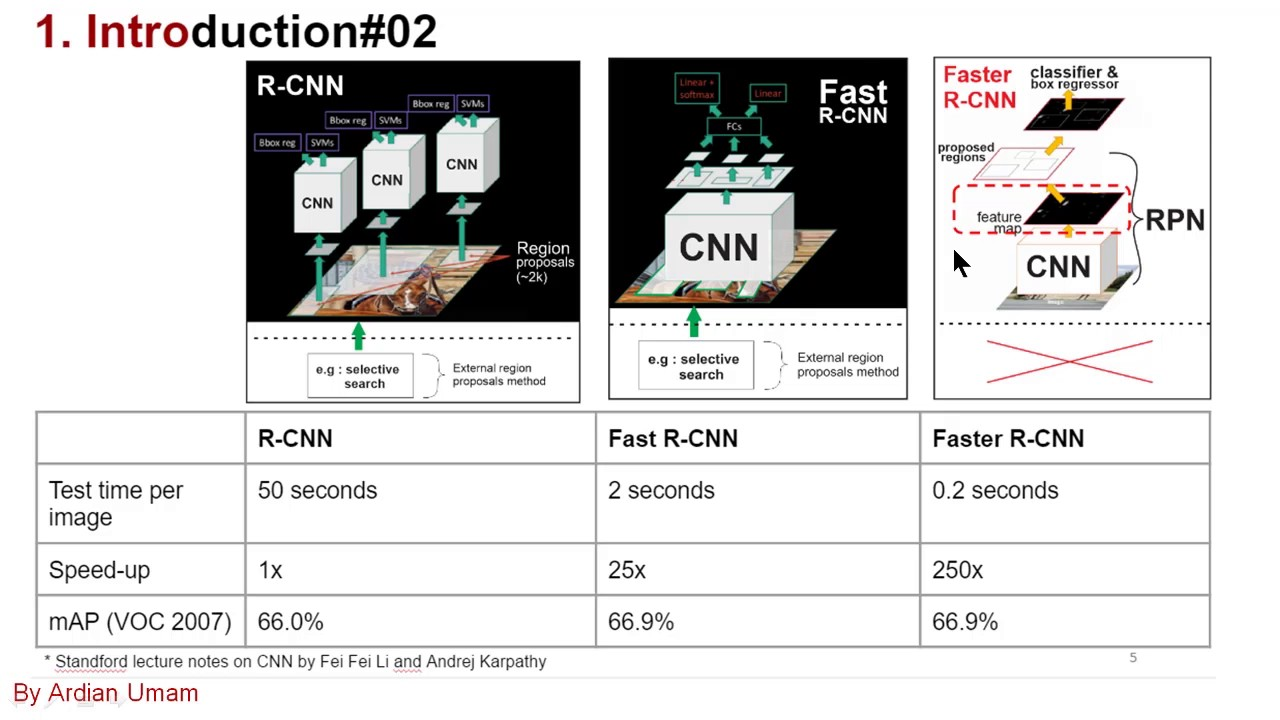

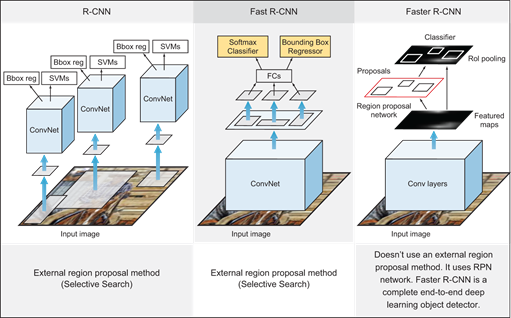

# Faster RCNN

### Selective Search for Object Recognition Paper :
http://huppelen.nl/publications/selectiveSearchDraft.pdf


### Source of the Faster RCNN Paper :
https://arxiv.org/pdf/1506.01497.pdf





Faster-rcnn is one of the most classic algorithms in the field of object detection. It mainly consists of two parts. One is a deep full convolutional network for generating candidate area frames, and the other is a Fast R-CNN detection model. The two share parameters during training.



Faster R-CNN can solve the problem that Fast RCNN uses the third-party tool selective search to extract the region proposal. It uses RPN instead of selective search to make the entire target detection function into a unified network. Faster RCNN uses RPN to make the calculation of region proposals more elegant and efficient. RPN is a full convolutional network. Candidate region generation and target detection share convolutional features. Attention mechanism is used . RPN will tell the network where to focus.


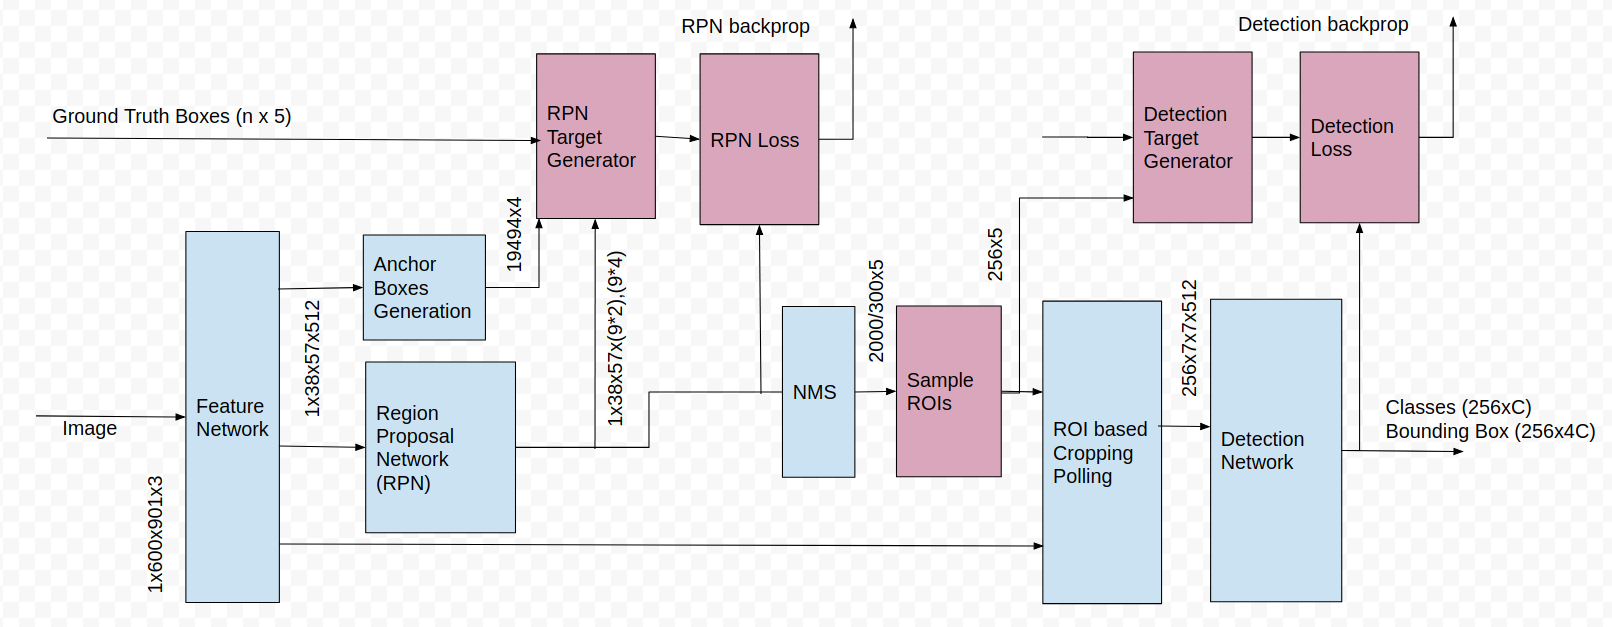

### RPN (Region Proposal network)

RPN is the core of faster rcnn. Its essence is a classless object detector based on sliding windows. There are multiple types of anchor boxes (region proposals) at each position of the image. Faster rcnn is trained with these region proposals. Classification and box regression pass Gradient descent backpropagation adjusts network parameters, regenerates the region proposal, and then continues training faster rcnn, repeating this process continuously.

### Structure


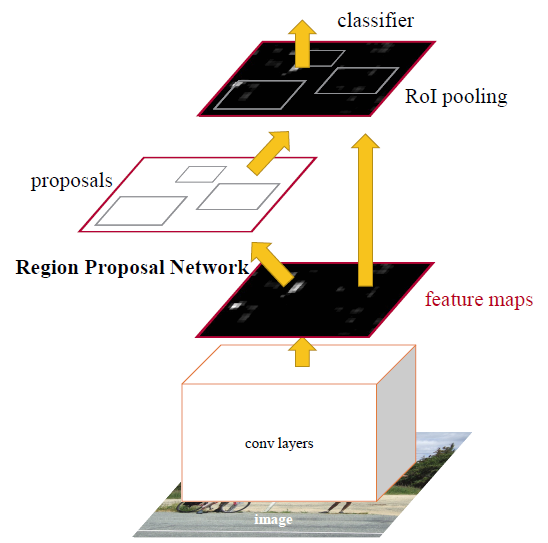

1. Conv layers: It is mainly composed of the basic conv + relu + pooling layers, which are used to extract the feature map in the image. Used for later shared RPN layers and fully connected layers.
2. region proposal networks (RPN): mainly used to generate region proposals. Use softmax to classify the candidate box (whether the background image is positive or negative), and use bbox to perform regression correction on the candidate box to obtain the proposals.
3.RoI pooling: Collect feature maps and proposals, extract the proposal feature map, and send it to the subsequent fully connected layer to determine the target category.
4.classification: Use the proposal feature map to calculate the proposal category, and bbox regression again to obtain a more accurate positioning.

VGG16-fasterrcnn is shown in Figure 2. It can be seen that the algorithm steps of the model are:
(1). Reshape a P × Q network of any size into M × N, and then send it to the network.
(2). Use vgg16 network to extract the features of the image: feature map.
(3). The RPN layer undergoes a 3 × 3 convolution to generate the positive anchor and bbox regression offsets, and calculates the proposals.
(4). The RoI layer uses the proposals to extract the proposals feature from the feature map and sends them to the subsequent full connection and softmax network for bbox_pre and classification.

Conv layers
As shown in Figure 2, using the VGG16 model as the network infrastructure, Conv layers has 13 conv layers, 13 relu layers, and 4 pooling layers. Here, the convolution operation has a general formula that gives the input image X × X. If kernel_size, padding, and stride are all given, then the dimension of the output is:



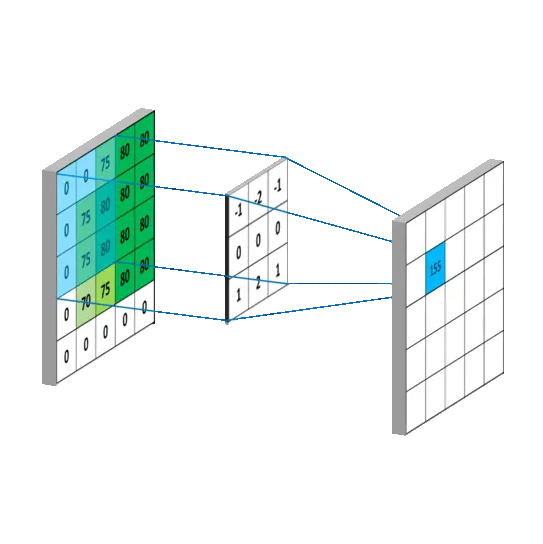


X = \ lfloor \ frac {X + 2padding-kernelsize} {stride} \ rfloor+ 1
where, as shown in the figure Calculation process:

Therefore, an M × N proof can be changed to (M / 16) × (N / 16), so that the feature map generated by the conv layers can correspond to the original image.

### RPN

The classical detection methods are very time-consuming. Faster rcnn can use RPN to automatically generate candidate frames, which greatly improves the speed of generating candidate frames.


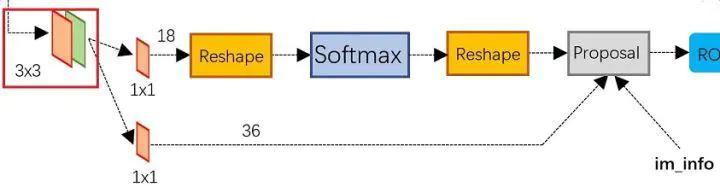

Figure 4 is the RPN structure diagram. It can be seen that RPN actually has two lines. The above is to obtain positive and negative anchors using softmax classification. The following is to calculate the offset of bbox and correct the position. The final layer of the proposal is responsible for synthesizing the positive anchors corresponding to the bbox regression offset to obtain the proposals, while deleting the proposals that are too small and exceed the boundary. To the proposal layer, the function of target positioning is completed.


### Multi-channel image convolution basics

For multi-channel multi-convolution kernels to do convolution, the calculation method is as follows:

Input 3 channels and 2 convolution kernels at the same time. For each convolution kernel, first input 3 channels for convolution, and then add the results of the 3 channels to obtain the convolution output.
For multi-channel 1 × 1 convolution, multiplying each channel of the input image by a convolution coefficient and adding them together is equivalent to “linking together” the original independent channels.

### Anchors

Anchors primarily used to represent the position of the candidate box ( , , , ) for the upper left corner and lower left coordinates. There are three types of aspect ratio: {1: 1,2: 1,1: 2}. As shown in Figure 6, through the introduction of commonly used multi-scale methods by anchors, anchors can basically cover all scales and shapes.


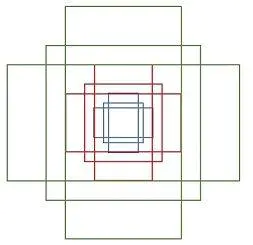

What do these 9 anchors do? As shown in Figure 7, each point of the feature maps is conveniently calculated by Conv layers, and is equipped with 9 kinds of initial detection frames. There are two bbox regressions to get the position of the modified candidate box.


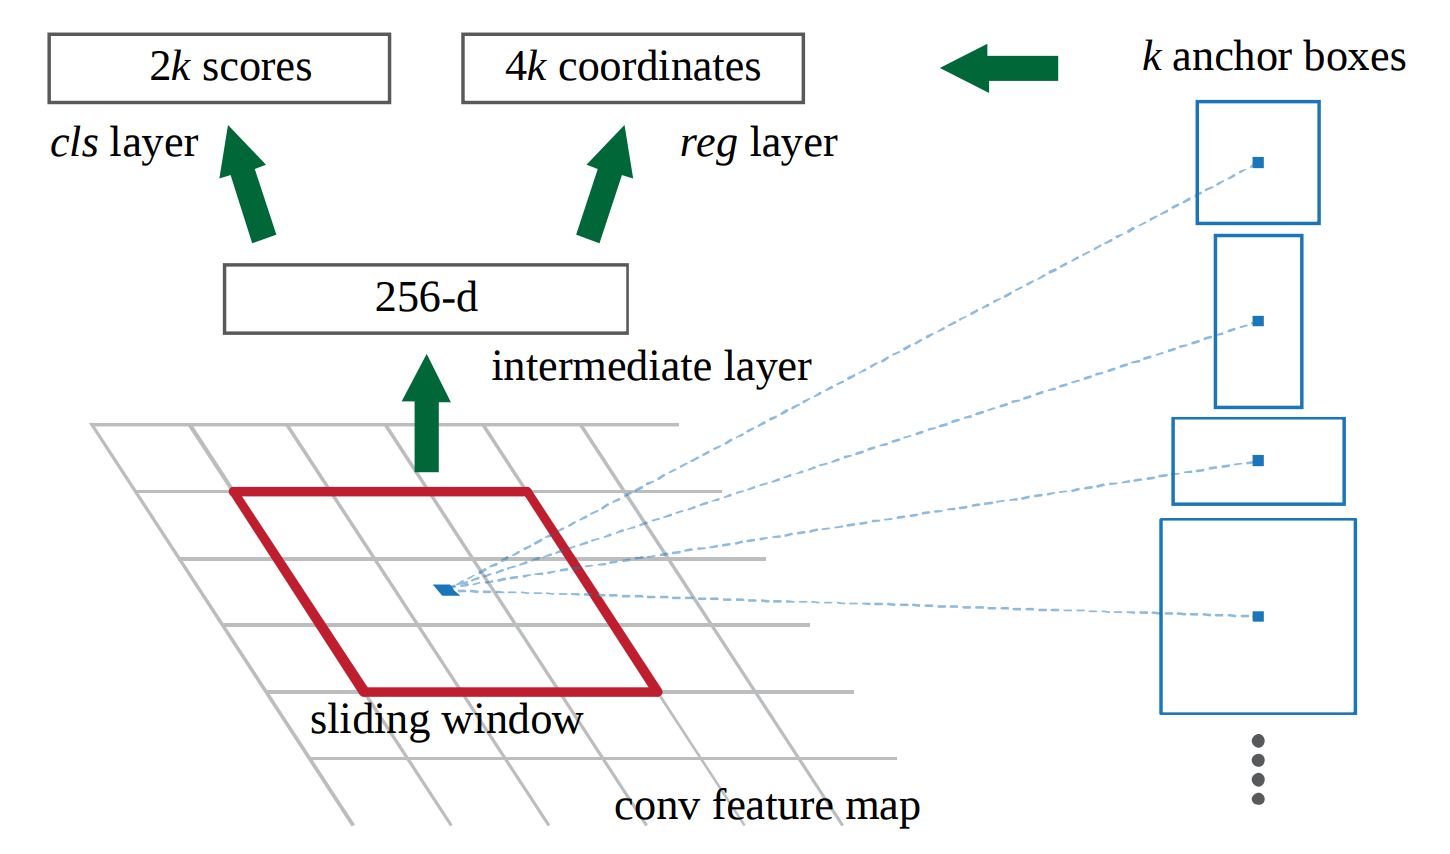

Explain the numbers in Figure 7:

1. The original uses the ZF model. The last conv5 layer generates num_output = 256, corresponding to 256 feature maps, so each point has 256 dimensions.

2. After conv5, do rpn_conv / 3 3 convolution and nun_ouput = 256, which is equivalent to fusing the surrounding 3 3 spatial information at each point , which is equivalent to fusing the surrounding 3 × 3 information, which is more robust. The red boxes of Figures 4 and 7.

3. Assume that each point in the conv feature map has k anchors, and each anchor is divided into positive and negative, so each point is converted from 256d feature to cls = 2k scores; each anchor has (x, y, w , h) corresponds to 4 offsets, so reg = 4k position.

4. All anchors take too much training. The training will randomly select 128 positive anchors and 128 negative anchors in the verified anchors for training.

In fact, the RPN is added with many candidate box anchors in the original picture. Then use cnn to determine which anchors have a positive anchor in the target and which negative anchors do not have a target, so it is only a two-class classification.

So how many anchors are there? Assuming the original image is 800 × 600, VGG is down-sampled 16 times, and 9 anchors are set for each point of the feature map, so:
ceil (800/16) × ceil (600/16) × 9 = 50 × 38 × 9 = 17100




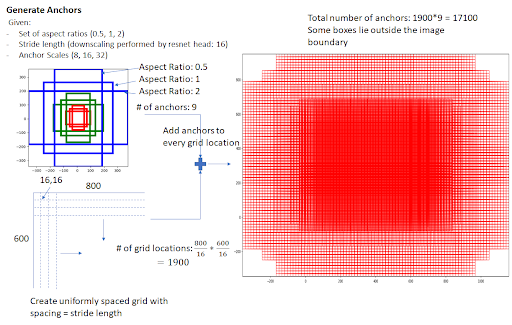

Using softmax to determine positive and negative
After the MxN-sized image is sent to the Faster RCNN network, the RPN network becomes (M / 16) x (N / 16). It is better to set W = M / 16 and H = N / 16. Before entering reshape and softmax, do a 1x1 convolution, as shown in Figure 9


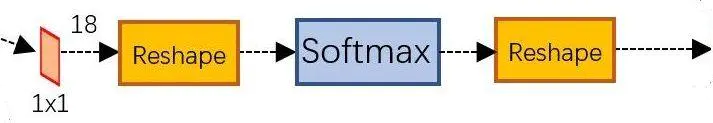

The output image after convolution is W × H × 18. There are exactly 9 anchors for each point in the feature maps. At the same time, each anchor may be positive and negative. All this information is stored in a W × H × (9 × 2) size matrix. Why did you do this? Later, the softmax classifies the positive anchors, that is, the box (in the positive anchors) of the preliminary detection target area is initially extracted.
Why connect a reshape layer before and after softmax? In fact, it is just for the convenience of softmax classification. Corresponding to the above matrix holding positive / negative anchors, its storage form in caffe blob is [1, 2x9, H, W]. In the softmax classification, a positive / negative binary classification is required, so the reshape layer will change it to a size of [1, 2, 9xH, W], that is, a dimension is vacated separately for the softmax classification, and then the reshape returns to its original state.
In summary, the RPN network uses anchors and softmax to initially extract positive anchors as candidate frames.

### BoundingBox Regression principle

As shown in Figure 10, the green frame is the Ground Truth (GT) of the aircraft, and the red is the extracted positive anchors. Even if the red frame is recognized by the classifier as an aircraft, but the red frame is not positioned correctly, this picture is equivalent to no The aircraft was correctly detected. So we hope to use a method to fine-tune the red box to make the positive anchors and GT closer.


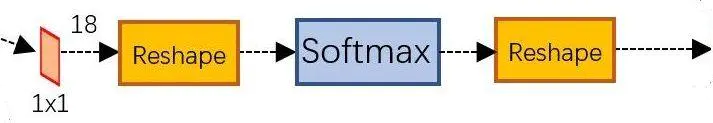

For windows, use the representation, which represents the center coordinates and width and height, respectively. For Figure 11, the red box A represents the original positive anchors, and the green box G represents the target GT. Our goal is to find a relationship so that after inputting the original A, a box G` and G are very close.`


### BoundingBox Regression on proposals


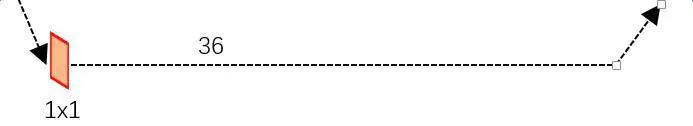

After this convolution, the output image is W × H × 36, and the storage form is [1,4 × 9, H, W]. Each point here has 9 anchors, and each anchor has four regression variables:
in FIG. 8, VGG output 50 38 is feature 256, provided corresponding to 50 38 is K th anchors, RPN output:

1. the size of 50 38 is positive / negative classification characteristic matrix 2k

2. the size of 50 38 is regression regression matrix coordinates 4k



### Proposal layer
This layer is responsible for synthesizing all the transform amounts and positive anchors, calculating accurate proposals, and inputting them to the subsequent ROI Pooling Layer. He has three inputs: the classification results of positive negative anchors, the corresponding bbox reg transformation amounts, rpn_bbox_pred and im_info, and feat_stride = 16.
As shown in Figure 13, im_info = [M, N, scale_factor = 1/16] holds all the scaling information for calculating the offset of the anchor.


The order of the proposal layer forward is:

1. Generate anchors, and use bbox regression for all anchors. (Generating anchors is exactly the same as training)

2. Sort the anchors in descending order according to the input positive scores, and extract the topN anchors, that is, extract the positive anchors after the correction position.

3. Limit the image positive to the boundary of the image.

4. Remove very small (definite length and width) positive anchors

5. Do NMS for the remaining positives

6. The proposals layer has three inputs: the classification results of positive and negative anchors, and the corresponding bbox reg results as the proper input.

The subsequent output is proposal = [x1, y2, x2, y2]. The output here corresponds to the scale of M * N. The detection ends here.
To summarize, RPN is to
generate anchors-> softmax classifier to extract positive anchors-> bbox reg regression to positive anchors-> proposal layer to generate proposals


### RoI pooling

RoI pooling is responsible for generating and collecting the proposal, and calculating the proposal feature maps, and sending it to the subsequent network. From Figure 2 we can see that RoI pooling has two inputs:
1. Original feature maps
2. Proposal boxes output by RPN (not the same size !!!)

#### Why do RoI pooling
For traditional CNN (VGG, ResNet), when the network is trained, the input image size must be a fixed value, and the network output is also a fixed-size vector. If the input dimensions of the images are not the same, it becomes very troublesome. There are two methods to solve:

1. Crop part from the image and transfer it to the network 

2. Warp the image to the required size


It can be seen that no matter which method is adopted, either the complete structure of the image is destroyed after crop, or the original shape information of the image is destroyed by warp. RoI pooling is to solve the problem of how to deal with different sizes.

### RoI pooling principle

RoI works as follows:

Since the proposal corresponds to the M * N size, it is first mapped back to the size of the feature map (1/16) using the spatial_scale parameter.
The feature map area corresponding to each proposal is divided into a grid -max_pooling is performed on each part of the grid.

After this processing, the output results of the proposals even if the size is different are fixed. Figure 15 shows the implementation of fixed-length output.

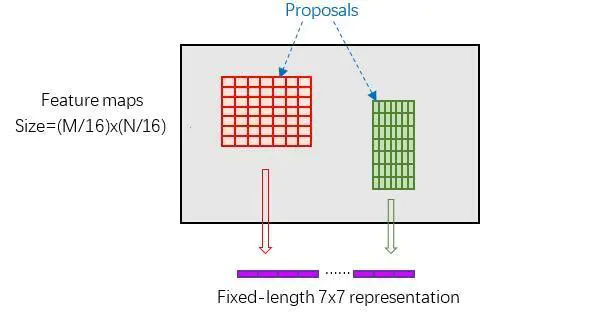

#### Classification
The input of the Classification part is the proposal feature maps. Through the full connect layer and softmax, calculate which category (person car television) each proposal belongs to, and output the cls_prob probability vector. At the same time, use bbox regression again to obtain the position offset bbox_pred of each proposal. Return to a more accurate detection frame. The classification network diagram is shown below


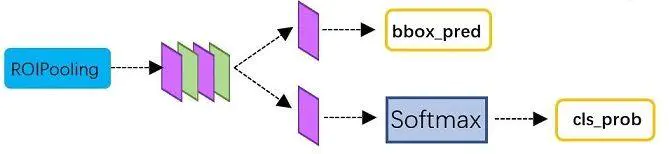

After getting 7 × 7 = 49 size feature feature maps from RoI pooling and sending it to the subsequent network, you can see that two things have been done:
1. classify the properties by full connection and softmax 2. perform bbox regression on the properties again, Get more accurate rect box
here to see the whole schematic view of the connection layer 17


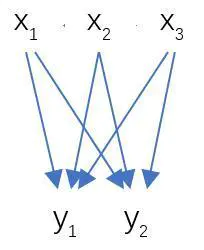

Calculated as follows:


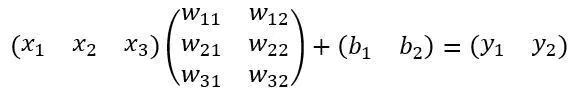

W and b are both pre-trained and the size is fixed. Of course, X and Y are fixed. Therefore, the need for RoI pooling is confirmed here.


### Faster RCNN training

Faster rcnn continues to train on the basis of already trained models (VGG, resnet). In fact, the training process has the following 6 steps:

1. On the trained model, train the RPN network, corresponding to stage1_rpn_train.pt

2. Use the RPN network trained in step 1, collect proposals, corresponding to rpn_test.pt

3. First Train the Fast RCNN network twice, corresponding to stage1_fast_rcnn_train.pt

4. Train the RPN network twice, corresponding to stage2_rpn_train.pt

5. Use the RPN network trained in step 4 to collect the proposals, corresponding to rpn_test.pt

6. Train the Fast RCNN the second time Network, corresponding to stage2_fast_rcnn_train.pt The
training process is similar to "iteration", and it is looped twice. "A similar alternating training can be run for more iterations, but we have observed negligible improvements". Next, explain these six training processes, as shown in Figure 18.


### Training the RPN Network

VGG is pre-trained and features are extracted. All layers in the Conv layers are drawn together (VGG / ResNet), shown in red circle. 


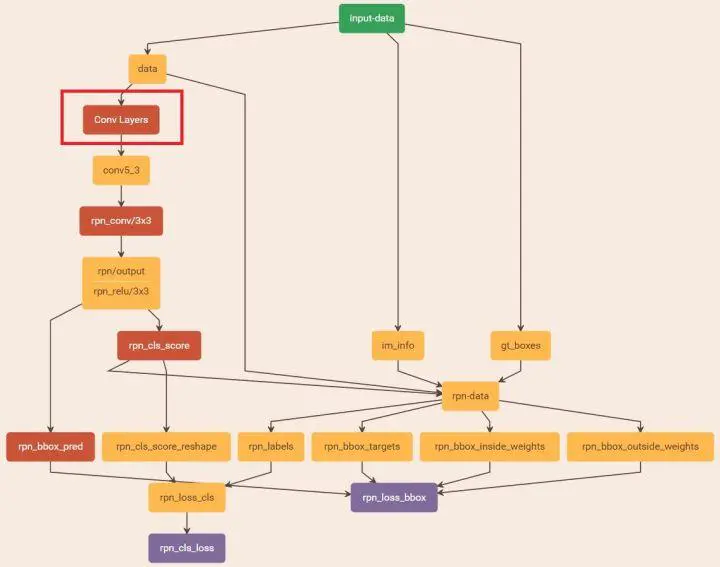

The Loss of the entire network is as follows: The

above formula represents the anchors index, the positive softmax probability, and the GT predict probability (when IoU of the i-th anchor and GT is greater than 0.7, the anchor is considered positive,
= 1, and IoU <0.3 is considered to be negative, = 0, 0.3 ~ 0.7 do not participate in training). t represents a predict bounding box, and represents a corresponding GT box. As you can see, Loss is divided into two parts:
1. cls losss oftmax network, used to classify anchors as positive and negative networks.
2.Reg loss The L1 loss calculated by the rpnlossbbox layer is used for bbox regression network training. I multiplied it because I only care about the positive anchor, not the negative.
Because the two are very far apart, use parameter balancing, such as: ,, settings. Here, smooth L1 loss is used, and the calculation formula is as follows:


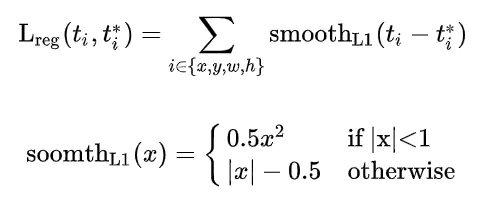

After understanding the mathematical principles, look at Figure 18 in reverse:
1. In the RPN training phase, the rpn-data layer will generate anchors for training in exactly the same manner as the proposal layer in the test phase.
2. For rpn_loss_cls, the input scores and
labels are 3. For rpn_loss_bbox, the input rpn_bbox_pred and rpn_bbox_target respectively correspond to and rpn_bbox_inside_weight.
The order of training and detection to generate storage anchors is exactly the same, so that the results can be used for detection.

Collecting Proposals Through a Trained RPN Network

The trained RPN network is used to obtain the Proposal RoI and obtain the positive softmax probability at the same time. As shown in Figure 20, the obtained information is stored in pickle. This network is essentially the same as the RPN network under test.

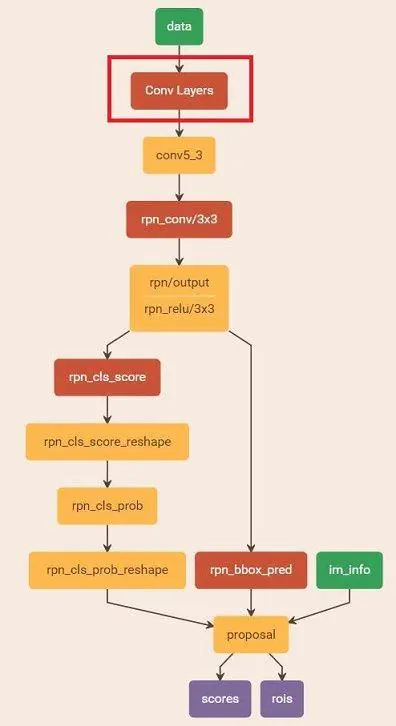








Training Faster RCNN Network

Read the previous pickle file to get the proposals and positive probability. The data layer is input to the network, and then:
1. The extracted proposals are transferred to the network as roi, as shown in the basket
2. Calculate bbox_inside_weights + bbox_outside_weights, the role is the same as RPN, and pass in the soomth_L1_loss layer, as shown in the green box in Figure 21

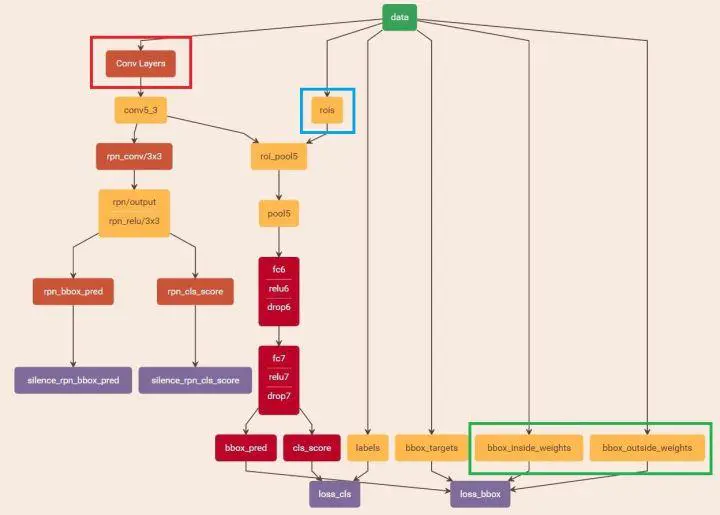

This will train the final softmax and the final bbox regression



### Conclusion of Faster RCNN

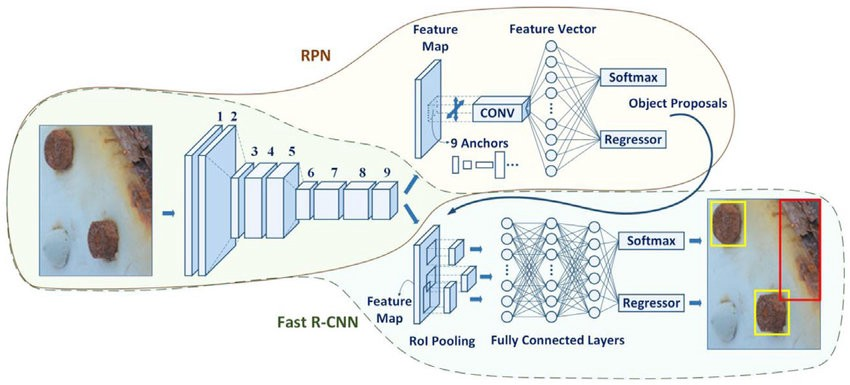

###  : Image as input to CNN
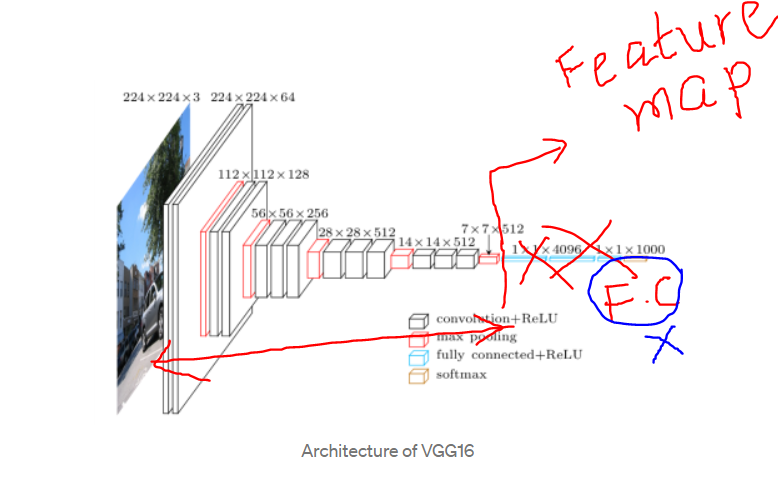

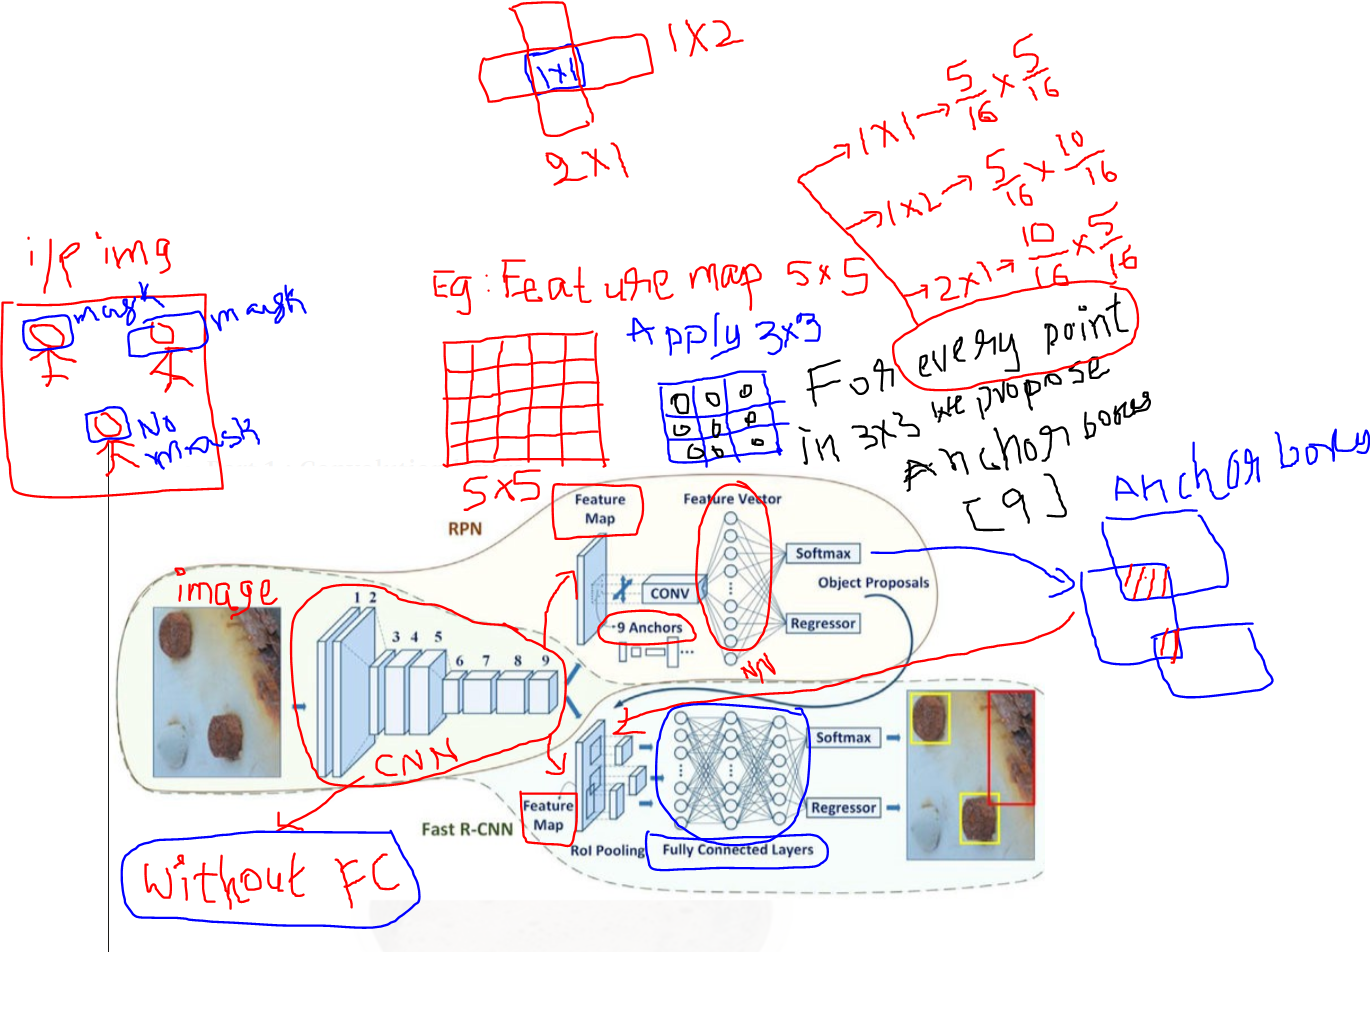

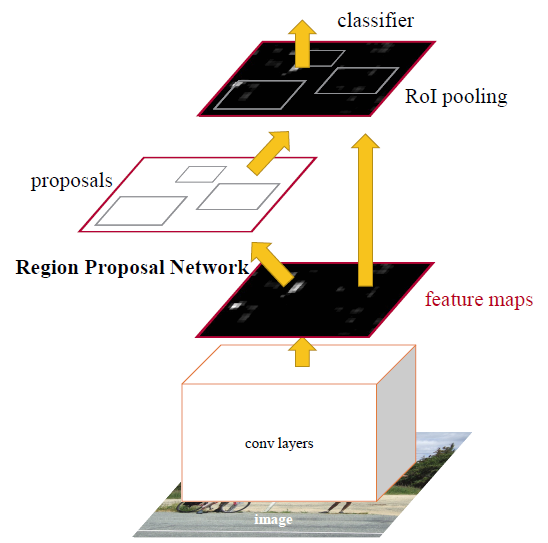

### Results :
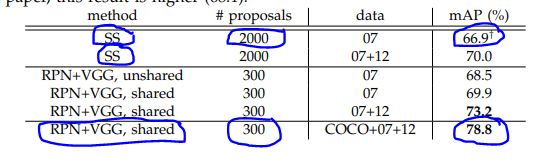

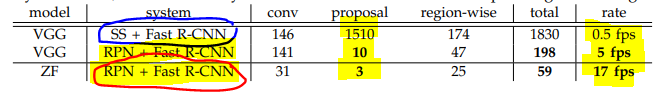

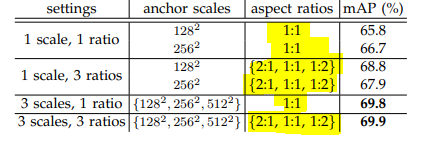